In [1]:
import pandas as pd
import numpy as np
import re
import json
import networkx as nx
from networkx.algorithms import bipartite 
import matplotlib.pyplot as plt

import community as community_louvain
import tqdm
from math import log


In [2]:
# load all tweet data
tweets = pd.read_csv("../../../data/tweets.csv")
tweets['hashtag'] = tweets['full_text'].apply(lambda x: re.findall(r'#(\w+)', x))
tweets["is_reply"] = [int(~np.isnan(tweet)) for tweet in tweets["in_reply_twitter_id"]]
tweets = tweets.rename(columns = {'id':'id_tweet'})

# load tweet topic data
tweet_topic = pd.read_csv("../../../data/tweet_topic.csv")

In [3]:
# load all processed tweets
with open("../../../ColombianPoliticsSentiment/final_lda_model/bow_corpus_all_records.json") as f:
    bow = json.load(f)

# load the dictionary
import gensim
dictionary_spanish = gensim.corpora.Dictionary.load("../../../ColombianPoliticsSentiment/final_lda_model/final_lda_model.model.id2word")

word_dict = {}
for x,y in dictionary_spanish.items():
    word_dict[x] = y

In [4]:
# add tweet id to bow
bow_alt = [[tweets['id_tweet'][idx], b] for idx, b in enumerate(bow)]

# remove empty tweets and replies from bow
bow_cl = [[b[0],b[1]] for b in bow_alt if len(b[1]) > 0]
tweet_ids = tweets['id_tweet'][tweets['is_reply'] == 0]
bow_cl = [[b[0],b[1]] for b in bow_cl if b[0] in tweet_ids]

# remove words that occur only once
word_count = {}
for b in bow_cl:
    for w,c in b[1]:
        try:
            word_count[w] += c
        except:
            word_count[w] = 0
            word_count[w] += c

word_remove = [w for w,c in word_count.items() if c < 5]
print(len(word_remove))

bow_cl = [[idx,[[w,c] for w,c in b if w not in word_remove]] for idx,b in bow_cl]

1899


In [5]:
# keep only original tweets
word_tweet_edges = []
word_nodes = []
for b in bow_cl:
    n_words = sum([c for w,c in b[1]])
    for w in b[1]:
        word_tweet_edges.append((word_dict[w[0]],b[0],w[1]/n_words))

In [6]:
word_G = nx.Graph()
word_G.add_weighted_edges_from(word_tweet_edges)
print(len(word_G.nodes()))
print(len(word_G.edges()))
# create list of word nodes
word_nodes = list(np.unique([j[0] for j in word_tweet_edges]))

2320
14763


In [7]:
# project network onto words
word_proj = bipartite.weighted_projected_graph(word_G,nodes = word_nodes,ratio=False)

print(len(word_proj.nodes()))
print(len(word_proj.edges()))

981
56951


In [8]:
# reformat the adjacency matrix to enable the use of neurotools
ordered_words = [w for w,d in word_proj.adjacency()]
word_to_index = dict(zip(ordered_words,list(range(len(ordered_words)))))
adj_matrix = np.zeros((len(ordered_words),len(ordered_words)))

for w,d in word_proj.adjacency():
    row_idx = word_to_index[w]
    for w2,wd in d.items():
        col_idx = word_to_index[w2]
        adj_matrix[row_idx, col_idx] = wd['weight']

In [17]:
import bct
from netneurotools import cluster 
repeats = 20
gammas = np.linspace(0.8,1.5,30)
communities = []
iteration = 1
for g in tqdm.tqdm(gammas):
    print(f'gamma value {iteration}: gamma = {g:.4f}')
    first_step = [bct.community_louvain(adj_matrix, gamma = g) for n in range(repeats)]
    cm, D = cluster.find_consensus(np.column_stack([t[0] for t in first_step]),return_agreement = True)
    second_step = bct.community_louvain(D, gamma = g, ci = cm)
    it = 1
    while sum(cm == second_step[0]) != adj_matrix.shape[0]:
        print(f'\tsecond step number {it}')
        cm, D = cluster.find_consensus(np.column_stack((cm,second_step[0])),return_agreement = True)
        second_step = bct.community_louvain(D, gamma = g, ci = cm)
        it += 1
        if it == 5: #sometimes the algorithm gets trapped in some local minimum or so, thus break out of the loop
            break
    communities.append(second_step)
    iteration += 1

  0%|                                                                                                                               | 0/10 [00:00<?, ?it/s]

gamma value 1: gamma = 0.1000


 10%|███████████▉                                                                                                           | 1/10 [00:16<02:29, 16.66s/it]

gamma value 2: gamma = 0.1556


 20%|███████████████████████▊                                                                                               | 2/10 [00:33<02:15, 16.93s/it]

gamma value 3: gamma = 0.2111


 30%|███████████████████████████████████▋                                                                                   | 3/10 [00:50<01:56, 16.68s/it]

gamma value 4: gamma = 0.2667


 40%|███████████████████████████████████████████████▌                                                                       | 4/10 [01:07<01:41, 16.89s/it]

gamma value 5: gamma = 0.3222


 50%|███████████████████████████████████████████████████████████▌                                                           | 5/10 [01:26<01:27, 17.55s/it]

gamma value 6: gamma = 0.3778


 60%|███████████████████████████████████████████████████████████████████████▍                                               | 6/10 [01:46<01:13, 18.46s/it]

gamma value 7: gamma = 0.4333


 70%|███████████████████████████████████████████████████████████████████████████████████▎                                   | 7/10 [02:05<00:55, 18.59s/it]

gamma value 8: gamma = 0.4889


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8/10 [02:26<00:38, 19.33s/it]

gamma value 9: gamma = 0.5444


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9/10 [02:47<00:20, 20.03s/it]

gamma value 10: gamma = 0.6000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:10<00:00, 19.04s/it]


In [18]:
from sklearn.metrics import normalized_mutual_info_score
# calculate the mutual information for different resolution parameters
MI = [np.nan]
for j in range(len(communities)):
    MI.append(normalized_mutual_info_score(communities[j][0],communities[j+1][0]))
    if j == len(communities)-2:
        break

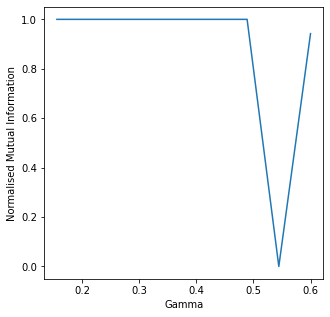

In [19]:
# plot mutual information for different resolution parameters
plt.figure(figsize = (5,5))
plt.plot(gammas,MI)
plt.xlabel("Gamma")
plt.ylabel("Normalised Mutual Information")
plt.savefig("resolution_tuning.png",dpi = 500)
plt.show()

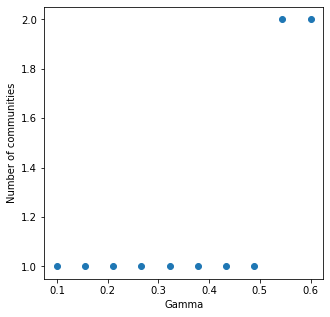

In [20]:
plt.figure(figsize = (5,5))
plt.scatter(gammas,[len(np.unique(p[0])) for p in communities])
plt.xlabel("Gamma")
plt.ylabel("Number of communities")
plt.savefig("gamma_vs_communities.png",dpi = 500)
plt.show()

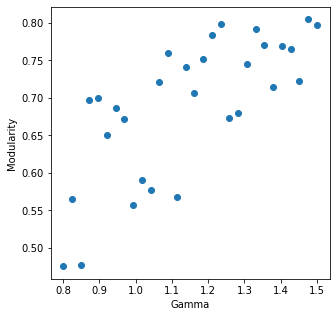

In [77]:
plt.figure(figsize = (5,5))
plt.scatter(gammas,[p[1] for p in communities])
plt.xlabel("Gamma")
plt.ylabel("Modularity")
plt.show()

In [82]:
# fit the final model using the suboptimal value of gamma
repeats = 250
first_step = [bct.community_louvain(adj_matrix, gamma = 1) for n in range(repeats)]
cm, D = cluster.find_consensus(np.column_stack([t[0] for t in first_step]),return_agreement = True)
second_step = bct.community_louvain(D, gamma = 1, ci = cm)
it = 1
while sum(cm == second_step[0]) != adj_matrix.shape[0]:
    print(f'\tsecond step number {it}')
    cm, D = cluster.find_consensus(np.column_stack((cm,second_step[0])),return_agreement = True)
    second_step = bct.community_louvain(D, gamma = 1, ci = cm)
    it += 1
    if it == 5: #sometimes the algorithm gets trapped in some local minimum or so, thus break out of the loop
        break

final_partition = second_step[0]

In [85]:
# create a dictionary assigning each word to a community
word_community_dict = dict(zip(ordered_words,final_partition))

# create a community_word_dictionary
community_word_dict = {}
for w,c in word_community_dict.items():
    try:
        community_word_dict[c] += [w]
    except: 
        community_word_dict[c] = []
        community_word_dict[c] += [w]

In [86]:
# assign each tweet to the "best community"
tweet_communities = []
for idx, b in bow_cl:
    com_count = dict(zip(list(community_word_dict.keys()),np.repeat(0,len(community_word_dict))))
    for w,n in b:
        com_count[word_community_dict[word_dict[w]]] += n
    community = list(com_count.keys())[np.argmax(list(com_count.values()))] 
    tweet_communities.append((idx,community))

In [87]:
print(len(word_proj.nodes()))
print(len(word_proj.edges()))

981
56951


In [88]:
# append the community as a property to each node
for i in word_proj.nodes:
    word_proj.nodes[i]['community'] = word_community_dict[i]

In [89]:
[len(community_word_dict[j]) for j in community_word_dict.keys()]

[245, 229, 68, 21, 317, 101]

In [90]:
# save network
nx.write_graphml(word_proj,'word_communities_network.graphml')

In [91]:
# compare to LDA community assignment
louvain_coms = pd.DataFrame({
    "id_tweet":[j[0] for j in tweet_communities],
    "louvain_community":[j[1] for j in tweet_communities]
})

louvain_coms = pd.merge(louvain_coms,tweet_topic[["id_tweet",'id_topic','lda_topic']],on = "id_tweet")

In [92]:
normalized_mutual_info_score(louvain_coms['louvain_community'], louvain_coms['id_topic'])

0.10008174738338885

In [93]:
normalized_mutual_info_score(louvain_coms['louvain_community'], louvain_coms['lda_topic'])

0.1082229701370916

In [94]:
normalized_mutual_info_score(louvain_coms['id_topic'], louvain_coms['lda_topic'])

0.9479406874048835

In [67]:
print(louvain_coms[louvain_coms['id_topic'] == 7])

      id_tweet  louvain_community  id_topic
0            1                  1         7
38          39                  5         7
47          48                  1         7
73          74                  5         7
76          77                  1         7
79          80                  1         7
81          82                  5         7
104        105                  5         7
146        148                  5         7
190        192                  5         7
228        230                  1         7
328        330                  5         7
370        372                  1         7
382        386                  1         7
384        388                  1         7
400        404                  1         7
428        433                  1         7
434        440                  1         7
443        449                  1         7
446        452                  1         7
459        466                  2         7
477        484                  